# Trabajo Práctico 2: Análisis con Voting - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo. También segmentamos el dataset en X e y (target):

In [6]:
df = traer_df()
df = preparar_dataset(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y test.

In [7]:
X, y = dividir_dataset(df)
X = aplicar_one_hot_encoding(X)
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

Asignamos los clasificadores a ser utilizados para realizar el ensamble. En este caso, utilizamos los que mejor ROC-AUC score proporcionaron: KNN, SVM y Random Forest, cada uno con sus mejores hiperparámetros.

In [8]:
clf_1 = KNeighborsClassifier(n_neighbors = 40, weights = 'uniform', metric = 'cosine')
clf_2 = SVC(kernel = 'rbf', C = 0.1, degree = 2, gamma = 0.01, probability = True)
clf_3 = RandomForestClassifier(max_depth = 16, n_estimators = 500, criterion = 'entropy')

Generamos el ensamble con los modelos anteriormente mencionados:

In [9]:
voting = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft', n_jobs = -1
)

## Entrenamiento y predicción con el dataset original

Normalizamos los datos del dataset original y entrenamos el modelo:

In [10]:
X_train, X_test = normalizar_datos(X_train_original, X_test_original)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('clf_1',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=40)),
                             ('clf_2',
                              SVC(C=0.1, degree=2, gamma=0.01,
                                  probability=True)),
                             ('clf_3',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=16,
                                                     n_estimators=500))],
                 n_jobs=5, voting='soft')

Ahora hacemos que este prediga sobre el subset de validation:

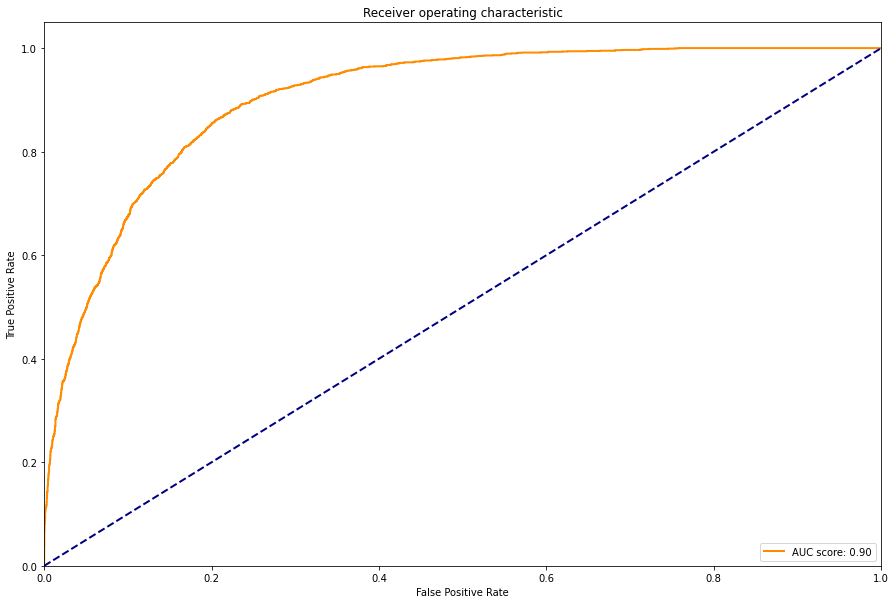

El valor de la metrica AUC-ROC para este modelo es: 0.9039933931831914


In [11]:
y_pred = voting.predict(X_test)
y_pred_proba = voting.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test, y_pred_proba)

Se puede ver un AUC score muy elevado, que tiene sentido, ya que realizamos una votación entre los modelos con mejor rendimiento.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [12]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.866     0.937     0.900      6181
   Tiene Alto Valor Adquisitivo      0.732     0.541     0.622      1960

                       accuracy                          0.842      8141
                      macro avg      0.799     0.739     0.761      8141
                   weighted avg      0.834     0.842     0.833      8141



Observamos una alta precision y recall para las instancias con bajo valor adquisitivo. Sin embargo, las instancias con alto valor adquisitivo tienen un recall regular, a pesar de tener una alta precision. Esto se ve más claramente en la matriz de confusión, donde se ve que Voting clasifica muy bien a los ceros, y decentemente a los unos.

In [13]:
from funciones_auxiliares import graficar_matriz_confusion

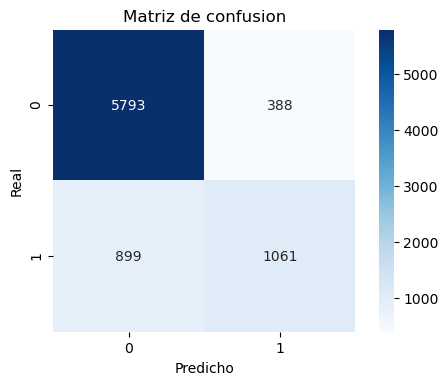

In [14]:
graficar_matriz_confusion(y_test, y_pred)

Se puede observar que el ensamble tiene una clara tendencia a predecir instancias de bajo valor adquisitivo, ya que predijo un 46% de las instancias de alto valor adquisitivo como de bajos ingresos. Esto está relacionado con el recall regular para esas instancias mencionado anteriormente, de 0.541.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train_original, X_exp_test_original, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0, stratify=y)

Generamos el ensamble para el dataset expandido con los modelos anteriormente mencionados:

In [17]:
voting_expandido = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft', n_jobs = -1
)

Normalizamos los datos del dataset ampliado y entrenamos el modelo:

In [18]:
X_exp_train, X_exp_test = normalizar_datos(X_exp_train_original, X_exp_test_original)
voting_expandido.fit(X_exp_train, y_exp_train)

VotingClassifier(estimators=[('clf_1',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=40)),
                             ('clf_2',
                              SVC(C=0.1, degree=2, gamma=0.01,
                                  probability=True)),
                             ('clf_3',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=16,
                                                     n_estimators=500))],
                 n_jobs=5, voting='soft')

Ahora hacemos que este prediga sobre el subset de validation:

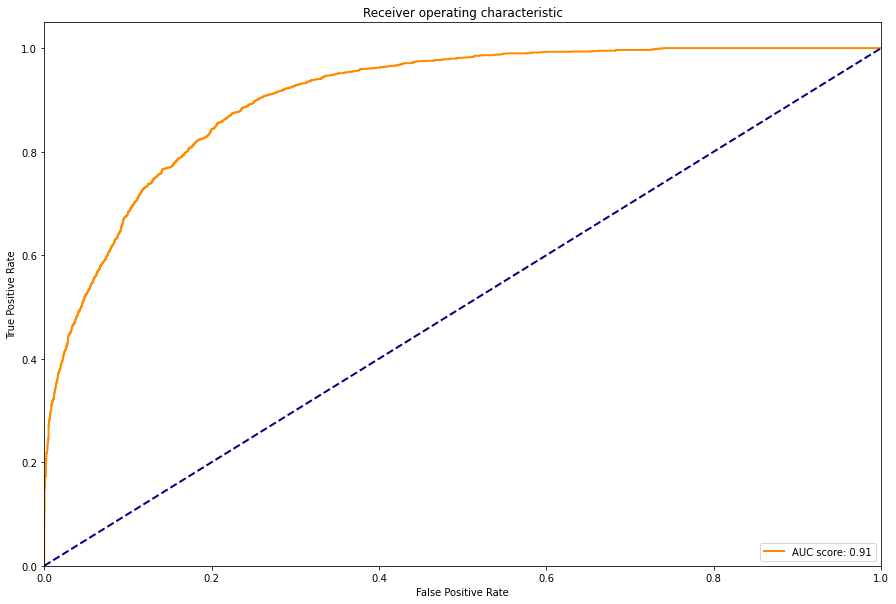

El valor de la metrica AUC-ROC para este modelo es: 0.9063099062631038


In [19]:
y_pred = voting_expandido.predict(X_exp_test)
y_pred_proba = voting_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que el AUC score dio muy alto, incluso levemente mejor al del dataset original. Tiene sentido, ya que estamos haciendo una votación entre varios modelos que tuvieron un score alto.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [20]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.871     0.938     0.903      6181
   Tiene Alto Valor Adquisitivo      0.742     0.560     0.638      1960

                       accuracy                          0.847      8141
                      macro avg      0.806     0.749     0.771      8141
                   weighted avg      0.840     0.847     0.839      8141



Se puede ver una alta precision y recall para las instancias con bajos ingresos. Para los de altos ingresos, se ve una precision relativamente alta, y un recall regular. La predicción se ve más claramente en la siguiente matriz de confusión:

In [21]:
from funciones_auxiliares import graficar_matriz_confusion

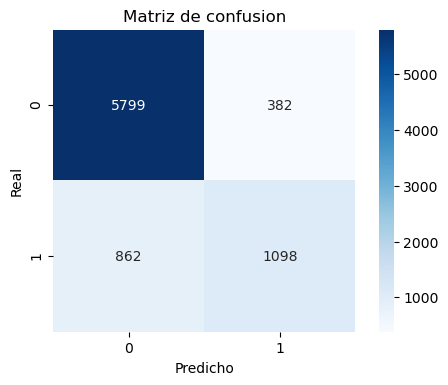

In [22]:
graficar_matriz_confusion(y_test, y_pred)

La tendencia a predecir instancias de bajo valor adquisitivo persiste, pero se hace menos fuerte con el dataset expandido, mejorando levemente el recall.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con Voting con el dataset ampliado (ya que este tuvo una mejor performance según AUC-ROC) sobre el dataset de predicciones nuevo, y la escribimos al archivo 'Voting.csv'

In [23]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [24]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)
X_exp_train_normalizado, df_predicciones = normalizar_datos(X_exp_train_original, df_predicciones)

In [25]:
predicciones = voting_expandido.predict(df_predicciones)
escribir_predicciones(ids, predicciones, "Voting")